<a href="https://colab.research.google.com/github/huzaifa003/eyelashes/blob/main/Eyelash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2024-09-21 18:27:33--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  40.2MB/s    in 1.5s    

2024-09-21 18:27:35 (40.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



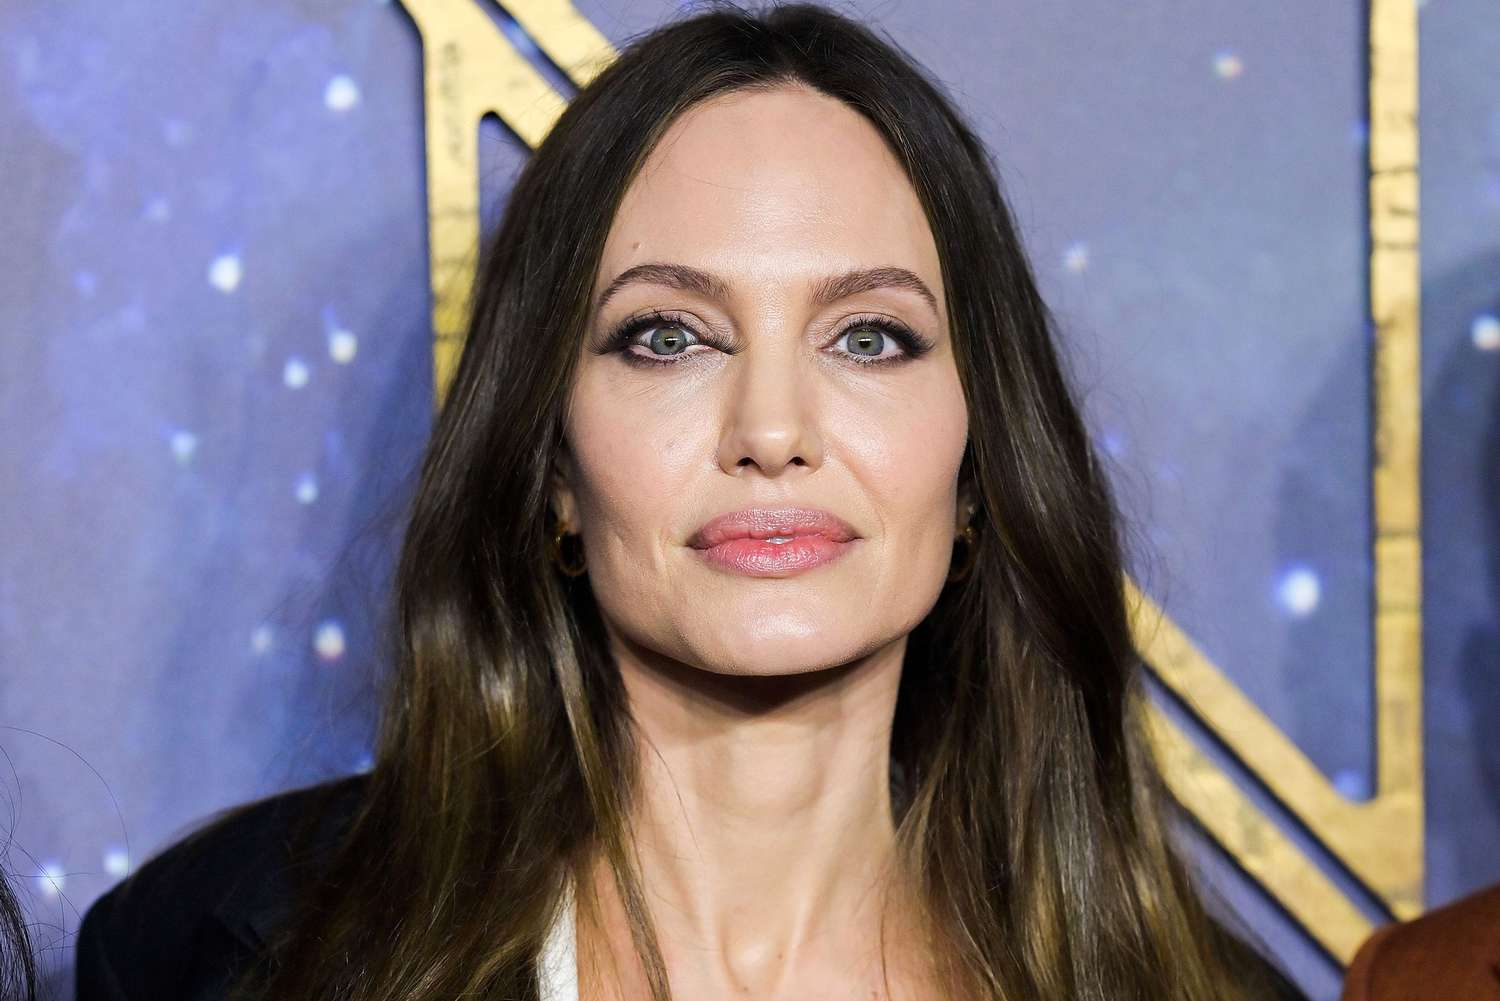

In [ ]:
import cv2
import dlib
import numpy as np
from google.colab.patches import cv2_imshow

# Load the user's image
user_image = cv2.imread('angeline.jpg')

# Load the eyelash image with an alpha channel
eyelash_image = cv2.imread('eyelash.png', cv2.IMREAD_UNCHANGED)

# Initialize face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Convert the image to grayscale
gray_image = cv2.cvtColor(user_image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = detector(gray_image)

for face in faces:
    # Get facial landmarks
    landmarks = predictor(gray_image, face)

    # Get coordinates for left and right eyes
    left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)])
    right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)])

    # Calculate the center and size of each eye
    left_eye_center = left_eye_points.mean(axis=0).astype("int")
    right_eye_center = right_eye_points.mean(axis=0).astype("int")
    eye_width = int(np.linalg.norm(right_eye_center - left_eye_center))

    # Resize the eyelash image to match the eye width
    resized_eyelash = cv2.resize(eyelash_image, (eye_width, int(eyelash_image.shape[0] * eye_width / eyelash_image.shape[1])), interpolation=cv2.INTER_AREA)

    # Determine the position to place the eyelash image
    y_offset = left_eye_center[1] - int(resized_eyelash.shape[0] / 2)
    x_offset = left_eye_center[0] - int(resized_eyelash.shape[1] / 2)

    # Get the region of interest on the user's image
    y1, y2 = y_offset, y_offset + resized_eyelash.shape[0]
    x1, x2 = x_offset, x_offset + resized_eyelash.shape[1]

    # Check for boundaries
    if x1 < 0 or y1 < 0 or x2 > user_image.shape[1] or y2 > user_image.shape[0]:
        continue

    # Extract the alpha mask of the eyelash image
    alpha_eyelash = resized_eyelash[:, :, 3] / 255.0
    alpha_background = 1.0 - alpha_eyelash

    # Blend the images
    for c in range(0, 3):
        user_image[y1:y2, x1:x2, c] = (alpha_eyelash * resized_eyelash[:, :, c] +
                                        alpha_background * user_image[y1:y2, x1:x2, c])

# Display the result
cv2_imshow(user_image)


Experiment #02

In [3]:
import cv2
import dlib
import numpy as np

# Load the pre-trained models
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

def extract_eye_measurements(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = detector(gray)

    if not faces:
        print("No faces detected.")
        return None

    measurements = {}

    for face in faces:
        # Get facial landmarks
        landmarks = predictor(gray, face)

        # Left eye landmarks (points 36-41)
        left_eye_pts = np.array([(landmarks.part(n).x, landmarks.part(n).y)
                                 for n in range(36, 42)])
        # Right eye landmarks (points 42-47)
        right_eye_pts = np.array([(landmarks.part(n).x, landmarks.part(n).y)
                                  for n in range(42, 48)])

        # Calculate measurements
        for eye_pts, eye_label in zip([left_eye_pts, right_eye_pts],
                                      ['left_eye', 'right_eye']):
            # Eye width and height
            width = np.linalg.norm(eye_pts[0] - eye_pts[3])
            height = (np.linalg.norm(eye_pts[1] - eye_pts[5]) +
                      np.linalg.norm(eye_pts[2] - eye_pts[4])) / 2.0

            # Eye Aspect Ratio (EAR)
            ear = height / width

            # Store measurements
            measurements[eye_label] = {
                'width': width,
                'height': height,
                'aspect_ratio': ear,
                'landmarks': eye_pts
            }

    return measurements

# Usage example
image_path = 'angeline.jpg'
eye_measurements = extract_eye_measurements(image_path)

if eye_measurements:
    print("Eye Measurements:")
    for eye, data in eye_measurements.items():
        print(f"{eye.capitalize()}: Width={data['width']:.2f}, "
              f"Height={data['height']:.2f}, EAR={data['aspect_ratio']:.2f}")


Eye Measurements:
Left_eye: Width=84.15, Height=31.56, EAR=0.38
Right_eye: Width=81.02, Height=30.51, EAR=0.38


In [4]:
def classify_eye_shape(ear):
    if ear > 0.3:
        return 'Round'
    elif ear < 0.25:
        return 'Almond'
    else:
        return 'Average'

# Adding classification to measurements
for eye, data in eye_measurements.items():
    ear = data['aspect_ratio']
    eye_shape = classify_eye_shape(ear)
    eye_measurements[eye]['shape'] = eye_shape
    print(f"{eye.capitalize()} Shape: {eye_shape}")


Left_eye Shape: Round
Right_eye Shape: Round


In [22]:
style_profiles = {
    'Natural': {
        'length_multiplier': 0.3,
        'curl_options': ['J-curl', 'B-curl'],
        'volume': 'Light'
    },
    'Glamorous': {
        'length_multiplier': 0.5,
        'curl_options': ['C-curl'],
        'volume': 'Medium'
    },
    'Dramatic': {
        'length_multiplier': 0.7,
        'curl_options': ['D-curl', 'L-curl'],
        'volume': 'High'
    }
}


In [23]:
def recommend_lashes(measurements, style_preference, custom_params=None):
    recommendations = {}

    if style_preference == 'Customized' and custom_params:
        # Use user-provided custom parameters
        length_multiplier = custom_params.get('length_multiplier', 0.3)
        curl = custom_params.get('curl', 'C-curl')
        volume = custom_params.get('volume', 'Medium')
    else:
        # Get the style parameters
        style = style_profiles.get(style_preference, style_profiles['Natural'])
        length_multiplier = style['length_multiplier']
        curl_options = style['curl_options']
        volume = style['volume']

    for eye, data in measurements.items():
        shape = data['shape']
        width = data['width']

        # Calculate length
        length = width * length_multiplier

        # Select curl
        if style_preference != 'Customized':
            if shape == 'Round':
                curl = curl_options[0]
            elif shape == 'Almond':
                curl = curl_options[-1]
            else:
                curl = curl_options[0]

        recommendations[eye] = {
            'length': length,
            'curl': curl,
            'volume': volume
        }

    return recommendations

# Usage example
style_preference = 'Glamorous'  # User-selected style
lash_recommendations = recommend_lashes(eye_measurements, style_preference)

print("\nLash Recommendations:")
for eye, rec in lash_recommendations.items():
    print(f"{eye.capitalize()}: Length={rec['length']:.2f}, "
          f"Curl={rec['curl']}, Volume={rec['volume']}")



Lash Recommendations:
Left_eye: Length=42.07, Curl=C-curl, Volume=Medium
Right_eye: Length=40.51, Curl=C-curl, Volume=Medium


In [24]:
# Assuming eye_measurements and lash_recommendations are available
for eye in eye_measurements.keys():
    data = eye_measurements[eye]
    rec = lash_recommendations[eye]
    print(f"\n{eye.capitalize()} Details:")
    print(f"- Measurements: Width={data['width']:.2f}, "
          f"Height={data['height']:.2f}, EAR={data['aspect_ratio']:.2f}")
    print(f"- Shape: {data['shape']}")
    print(f"- Recommended Lash:")
    print(f"  - Length: {rec['length']:.2f}")
    print(f"  - Curl: {rec['curl']}")
    print(f"  - Volume: {rec['volume']}")



Left_eye Details:
- Measurements: Width=84.15, Height=31.56, EAR=0.38
- Shape: Round
- Recommended Lash:
  - Length: 42.07
  - Curl: C-curl
  - Volume: Medium

Right_eye Details:
- Measurements: Width=81.02, Height=30.51, EAR=0.38
- Shape: Round
- Recommended Lash:
  - Length: 40.51
  - Curl: C-curl
  - Volume: Medium


Experiment #03

In [25]:
def annotate_lash_info(image, eye_label, rec, data):
    # Choose a position below the eye
    x = int(data['landmarks'][3][0])
    y = int(data['landmarks'][3][1]) + 20  # Slightly below the eye

    # Prepare the text
    text = f"Lash: Length={rec['length']:.2f}, Curl={rec['curl']}, Volume={rec['volume']}"

    # Put the text on the image
    cv2.putText(image, text, (x, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)


In [26]:
def extract_eye_measurements(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = detector(gray)

    if not faces:
        print("No faces detected.")
        return None

    measurements = {}

    for face in faces:
        # Get facial landmarks
        landmarks = predictor(gray, face)

        # Left eye landmarks (points 36-41)
        left_eye_pts = np.array([(landmarks.part(n).x, landmarks.part(n).y)
                                 for n in range(36, 42)])
        # Right eye landmarks (points 42-47)
        right_eye_pts = np.array([(landmarks.part(n).x, landmarks.part(n).y)
                                  for n in range(42, 48)])

        # Calculate measurements
        for eye_pts, eye_label in zip([left_eye_pts, right_eye_pts],
                                      ['left_eye', 'right_eye']):
            # Eye width and height
            width = np.linalg.norm(eye_pts[0] - eye_pts[3])
            height = (np.linalg.norm(eye_pts[1] - eye_pts[5]) +
                      np.linalg.norm(eye_pts[2] - eye_pts[4])) / 2.0

            # Eye Aspect Ratio (EAR)
            ear = height / width

            # **Classify Eye Shape**
            eye_shape = classify_eye_shape(ear)

            # Store measurements
            measurements[eye_label] = {
                'width': width,
                'height': height,
                'aspect_ratio': ear,
                'shape': eye_shape,  # Add the 'shape' key here
                'landmarks': eye_pts
            }

    return measurements


In [27]:
def classify_eye_shape(ear):
    if ear > 0.3:
        return 'Round'
    elif ear < 0.25:
        return 'Almond'
    else:
        return 'Average'


In [28]:
def draw_eye_landmarks(image, eye_landmarks):
    for point in eye_landmarks:
        x, y = point
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)


In [29]:
def annotate_eye_info(image, eye_label, data):
    # Choose a position to place the text
    x = int(data['landmarks'][0][0])
    y = int(data['landmarks'][0][1]) - 10  # Slightly above the first landmark

    # Prepare the text
    text = f"{eye_label.capitalize()} Eye: {data['shape']}"

    # Put the text on the image
    cv2.putText(image, text, (x, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


In [36]:
def annotate_lash_info(image, eye_label, rec, data):
    # Choose a position below the eye
    x = int(data['landmarks'][3][0])
    y = int(data['landmarks'][3][1]) - 20  # Slightly below the eye

    # Prepare the text
    text = f"Lash: Length={rec['length']:.2f}, Curl={rec['curl']}"

    # Put the text on the image
    cv2.putText(image, text, (x, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)


In [37]:
def overlay_lash(image, eye_landmarks, lash_image_path):
    # Load the lash image with alpha channel
    lash_image = cv2.imread(lash_image_path, cv2.IMREAD_UNCHANGED)

    # Calculate the eye region size and position
    eye_width = int(np.linalg.norm(eye_landmarks[0] - eye_landmarks[3]))
    eye_height = int(eye_width * lash_image.shape[0] / lash_image.shape[1])

    # Resize the lash image to match the eye width
    lash_resized = cv2.resize(lash_image, (eye_width, eye_height))

    # Calculate position
    x = int(eye_landmarks[0][0])
    y = int(eye_landmarks[0][1]) - int(eye_height / 2)

    # Overlay the lash image
    y1, y2 = y, y + lash_resized.shape[0]
    x1, x2 = x, x + lash_resized.shape[1]

    # Check image boundaries
    if x1 < 0 or y1 < 0 or x2 > image.shape[1] or y2 > image.shape[0]:
        return  # Skip if out of bounds

    # Extract the alpha mask of the lash
    alpha_lash = lash_resized[:, :, 3] / 255.0
    alpha_image = 1.0 - alpha_lash

    for c in range(0, 3):
        image[y1:y2, x1:x2, c] = (alpha_lash * lash_resized[:, :, c] +
                                  alpha_image * image[y1:y2, x1:x2, c])


In [38]:
def select_lash_image(rec, threshold_length=30):
    # Logic to select lash image based on length and curl
    length_category = 'short' if rec['length'] < threshold_length else 'long'
    curl_type = rec['curl'].lower()

    # Construct the filename
    filename = f"lashes_{length_category}_{curl_type}.png"
    lash_image_path = os.path.join('lash_images', filename)
    return lash_image_path



Left_eye Details:
- Measurements: Width=84.15, Height=31.56, EAR=0.38
- Shape: Round
- Recommended Lash:
  - Length: 25.24
  - Curl: J-curl
  - Volume: Light

Right_eye Details:
- Measurements: Width=81.02, Height=30.51, EAR=0.38
- Shape: Round
- Recommended Lash:
  - Length: 24.31
  - Curl: J-curl
  - Volume: Light


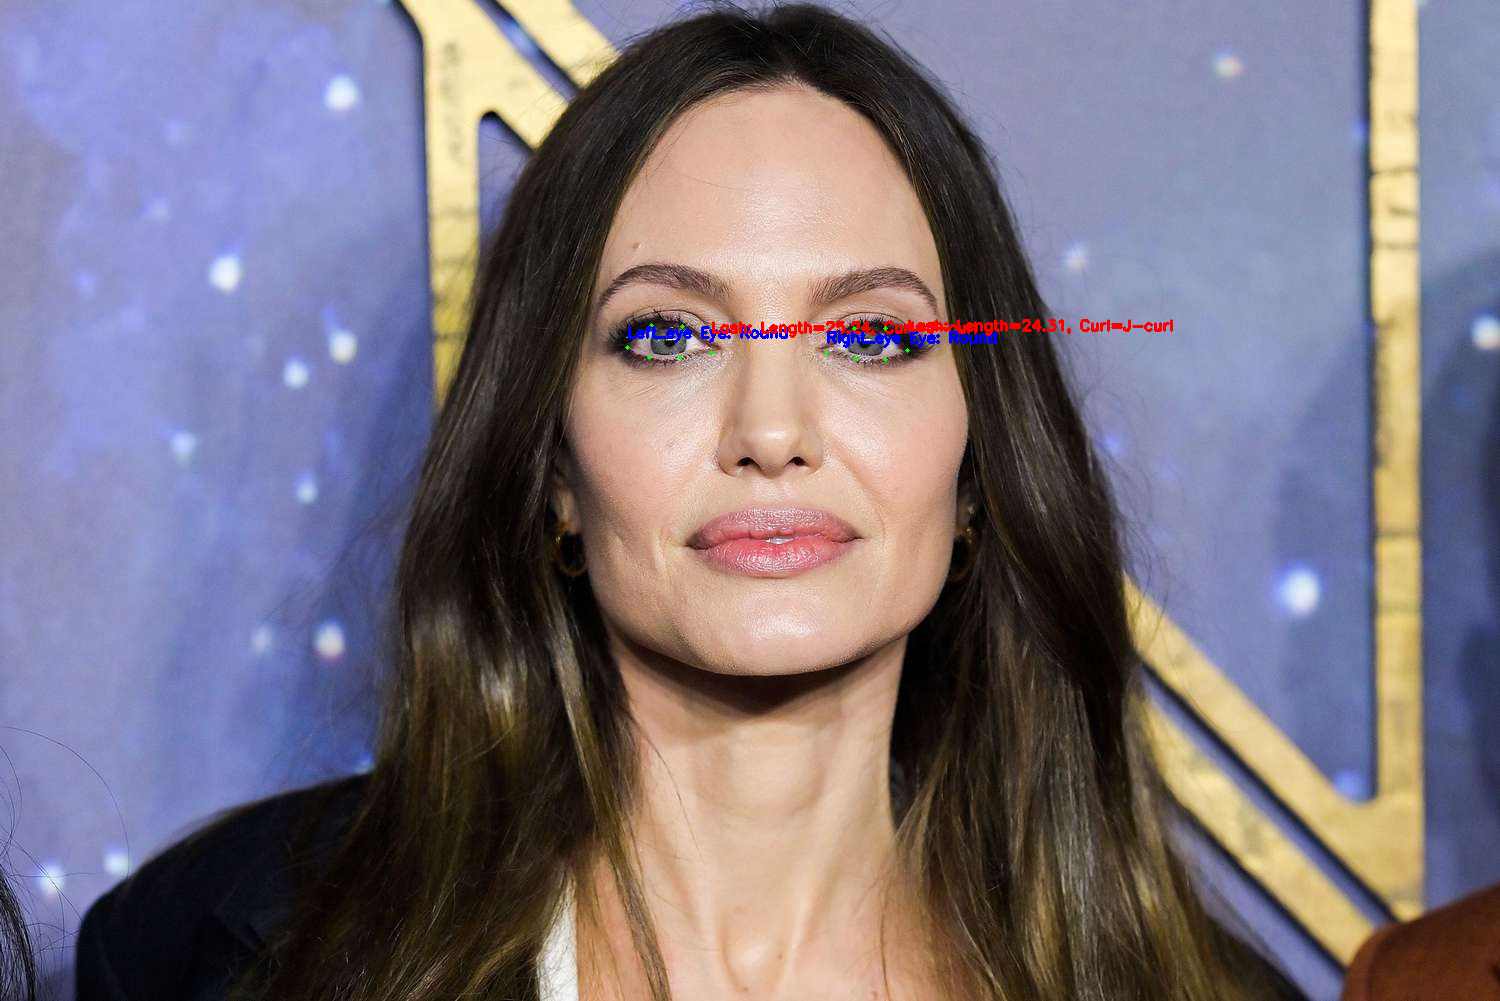

In [39]:
import cv2
import dlib
import numpy as np
import os
from google.colab.patches import cv2_imshow

# # Initialize face detector and shape predictor
# detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
# Load models and data as before...

# Visualization functions (as defined above)

# Load the image
image_path = 'angeline.jpg'
image = cv2.imread(image_path)

# Extract measurements and recommendations (assuming these functions are defined)
eye_measurements = extract_eye_measurements(image_path)
lash_recommendations = recommend_lashes(eye_measurements, style_preference='Natural')

# Visualization
for eye in eye_measurements.keys():
    data = eye_measurements[eye]
    rec = lash_recommendations[eye]

    print(f"\n{eye.capitalize()} Details:")
    print(f"- Measurements: Width={data['width']:.2f}, "
          f"Height={data['height']:.2f}, EAR={data['aspect_ratio']:.2f}")
    print(f"- Shape: {data['shape']}")
    print(f"- Recommended Lash:")
    print(f"  - Length: {rec['length']:.2f}")
    print(f"  - Curl: {rec['curl']}")
    print(f"  - Volume: {rec['volume']}")


    # Draw landmarks
    draw_eye_landmarks(image, data['landmarks'])

    # Annotate measurements and eye shape
    annotate_eye_info(image, eye, data)

    # Annotate lash recommendations
    annotate_lash_info(image, eye, rec, data)

    # Overlay lash images
    lash_image_path = select_lash_image(rec)
    #overlay_lash(image, data['landmarks'], lash_image_path)

# Display the image
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()
